# Самостоятельный проект


Нам необходимо выполнить задачу от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Характеристики:
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

In [2]:
!pip install -U skorch
import pandas as pd
import skorch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from torch.utils.data import Dataset, DataLoader
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor
from sklearn.metrics import fbeta_score, make_scorer

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.dataset import ValidSplit

from sklearn.metrics import mean_squared_error
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer

     |████████████████████████████████| 193 kB 1.6 MB/s eta 0:00:01


In [3]:
def df_vis(column_list, df):   
    for column in column_list:
        df.boxplot(column=column)
        plt.title(f'Диаграмма размаха на столбце {column}')
        plt.show()
        df[column].plot(kind='hist', bins=100, grid=True)
        plt.title(f'Гистограмма на столбце {column}')
        plt.xlabel(column)
        plt.ylabel('Кол-во наблюдений')
        plt.show()
        print('--------------------------------------------')

In [4]:
df = pd.read_csv('/datasets/6_class.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Рассмотрим наши данные на аномалии

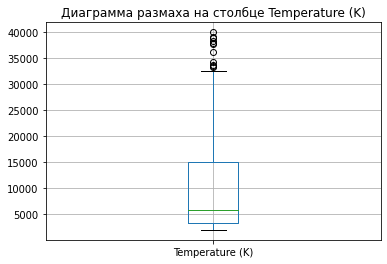

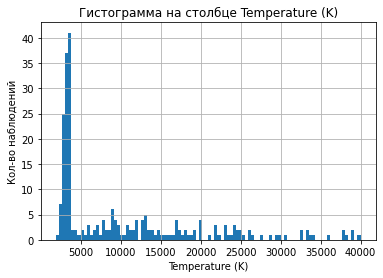

--------------------------------------------


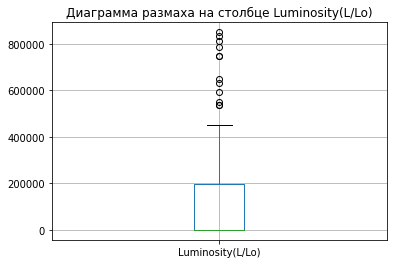

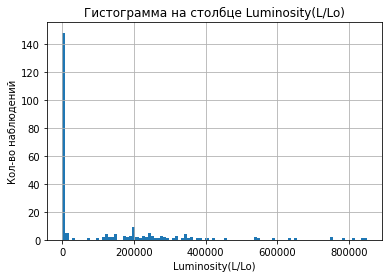

--------------------------------------------


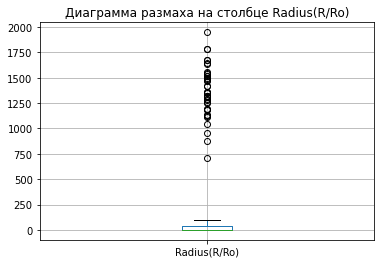

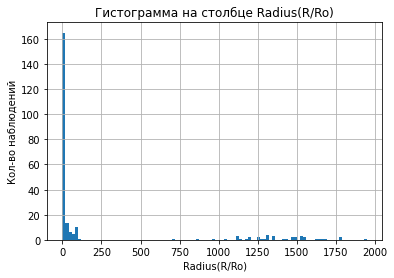

--------------------------------------------


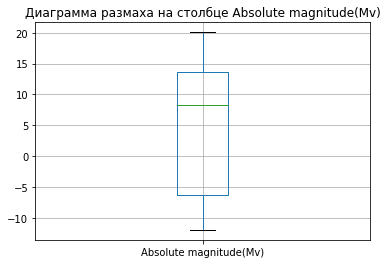

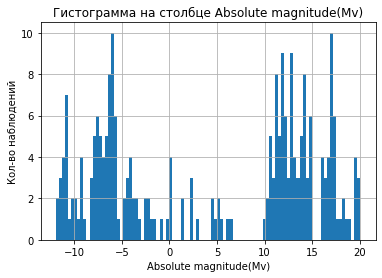

--------------------------------------------


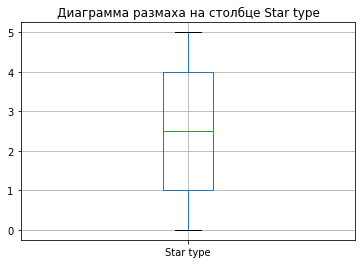

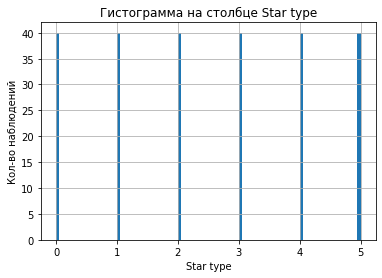

--------------------------------------------


In [6]:
df_vis(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type'], df)

Аномалии в естесственных пределах, т.е. имеют значеиня, достижимые природе, поэтому удалять их не будем.

In [7]:
display(df.corr())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
Temperature (K),1.000000,0.393404,0.064216,-0.420261,0.411129
Luminosity(L/Lo),0.393404,1.000000,0.526516,-0.692619,0.676845
Radius(R/Ro),0.064216,0.526516,1.000000,-0.608728,0.660975
Absolute magnitude(Mv),-0.420261,-0.692619,-0.608728,1.000000,-0.955276
Star type,0.411129,0.676845,0.660975,-0.955276,1.000000


Столбцы `Star type` и `Absolute magnitude(Mv)` коррелируют слишком сильно, однако т.к. наша сеть не линейная, это не должно вызвать переобучения, поэтому оставим всё как есть

In [8]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Избавимся от неявных дубликатов

In [9]:
df['Star color'] = df['Star color'].str.lower()
df['Star color'] = df['Star color'].str.strip(to_strip = None)
df['Star color'] = df['Star color'].replace('blue white', 'blue-white')
df['Star color'] = df['Star color'].replace(['yellow-white', 'yellowish white'], 'white-yellow')
df['Star color'] = df['Star color'].replace('whitish', 'white-yellow')
df['Star color'] = df['Star color'].replace(['orange','pale yellow orange'], 'orange-red')
df['Star color'].unique()

array(['red', 'blue-white', 'white', 'white-yellow', 'orange-red', 'blue',
       'yellowish'], dtype=object)

### Подготовка данных

In [10]:
num = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)','Star type']
cat = ['Star color']

Преобразуем категоральные переменные

In [11]:
'''OHE = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')

cat_df = pd.DataFrame(OHE.fit_transform(df.loc[:,cat]))
df.drop(cat, axis = 1, inplace = True)
df = pd.concat([df, cat_df], axis = 1)
df'''

"OHE = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')\n\ncat_df = pd.DataFrame(OHE.fit_transform(df.loc[:,cat]))\ndf.drop(cat, axis = 1, inplace = True)\ndf = pd.concat([df, cat_df], axis = 1)\ndf"

In [12]:
# Разделим нашу выборку
X_train, X_test_val, y_train, y_test_val = train_test_split(df.drop('Temperature (K)', axis = 1),
                                                    df['Temperature (K)'],
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144, 5) (48, 5) (144,) (48,)


Преобразуем числовые переменные

In [13]:
col_transformer = ColumnTransformer(
                    transformers=[
                        ('ss', StandardScaler(), num),
                        ('ohe', OneHotEncoder(drop='first', sparse=False), cat)
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

In [14]:
X_train = col_transformer.fit_transform(X_train)
X_val = col_transformer.transform(X_val)
X_test = col_transformer.transform(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X_train.shape

(144, 10)

## Построение базовой нейронной сети

In [14]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)
y_val = torch.FloatTensor(y_val.values)

In [15]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True,
                               num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=32, num_workers=0)

In [16]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                 n_hidden_neurons_4, n_out_neurons,p_value_1, p_value_2):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp1 = nn.Dropout(p=p_value_1)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)            
            self.act2 = nn.ReLU()
            self.dp2 = nn.Dropout(p=p_value_2)
            self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)            
            self.act3 = nn.ReLU()
            self.dp3 = nn.Dropout(p=p_value_1)
            self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
            self.act4 = nn.ReLU()
            self.dp4 = nn.Dropout(p=p_value_2)
            self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)  
            
    def forward(self, x):
        x = self.fc1(x)        
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.dp4(x)
        x = self.fc5(x)
        
        return x

In [17]:
n_in_neurons = 10
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 12
n_hidden_neurons_3 = 8
n_hidden_neurons_4 = 5
n_out_neurons = 1
p_value_1 = 0.2
p_value_2 = 0.5

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,n_hidden_neurons_3, n_hidden_neurons_4, n_out_neurons,p_value_1, p_value_2)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.NAdam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-2)

optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5]

loss = nn.MSELoss()

In [18]:
history = []

In [19]:
num_epochs = 100
batch_size = 40
num_batches = ceil(len(X_train)/batch_size)

for optimizer in optimizers:
    optimizer_rmse = []
    print(f'Оптимизатор {optimizer}:')

    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train))
        
        for batch_idx in range(num_batches):
            
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index : start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch.float()).flatten()

            loss_value = loss(preds, y_batch)            

            loss_value.backward()

            optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            net.eval()
            val_preds = net.forward(X_val.float()).flatten()
            ans = round(float(torch.sqrt(loss(val_preds, y_val))), 2)
            history.append(ans)
            print(f'Метрика RMSE на {epoch} итерации =', ans)
            optimizer_rmse.append(ans)
    print()
    print(f'Лучшая метрика RMSE = {min(optimizer_rmse)} обнаружена на {optimizer_rmse.index(min(optimizer_rmse))} эпохе')
    print(f'Средняя метрика RMSE = {round(np.mean(optimizer_rmse), 2)}')
    print('---------------------------------------------------------------------------------------------', '\n')

Оптимизатор Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
):
Метрика RMSE на 0 итерации = 15832.15
Метрика RMSE на 10 итерации = 15832.02
Метрика RMSE на 20 итерации = 15831.45
Метрика RMSE на 30 итерации = 15828.45
Метрика RMSE на 40 итерации = 15816.96
Метрика RMSE на 50 итерации = 15781.29
Метрика RMSE на 60 итерации = 15690.16
Метрика RMSE на 70 итерации = 15492.25
Метрика RMSE на 80 итерации = 15112.2
Метрика RMSE на 90 итерации = 14474.15
Метрика RMSE на 99 итерации = 13650.35

Лучшая метрика RMSE = 13650.35 обнаружена на 10 эпохе
Средняя метрика RMSE = 15394.68
--------------------------------------------------------------------------------------------- 

Оптимизатор NAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    momentum_decay: 0.004
    weight_decay: 0
):
Метрика RMSE на 0 итерации = 13216.69
Метрика RMSE на 10 итерации = 9602.06
Метрика RMSE на 20 итерации = 8826.32
Метри

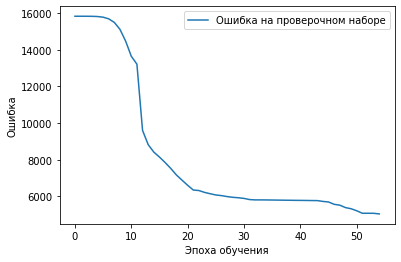

In [20]:
plt.plot(history, label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [21]:
# Проверим модель на тестовых данных

num_epochs = 100
batch_size = 40
num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):

    order = np.random.permutation(len(X_train))

    for batch_idx in range(num_batches):

        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        batch_indexes = order[start_index : start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch.float()).flatten()

        loss_value = torch.sqrt(loss(preds, y_batch))
        

        loss_value.backward()

        optimizer5.step()
        
net.eval()
test_preds = net.forward(X_test.float()).flatten()
ans = round(float(torch.sqrt(loss(test_preds, y_test))), 2)
print(f'Метрика RMSE =', ans)

Метрика RMSE = 4124.49


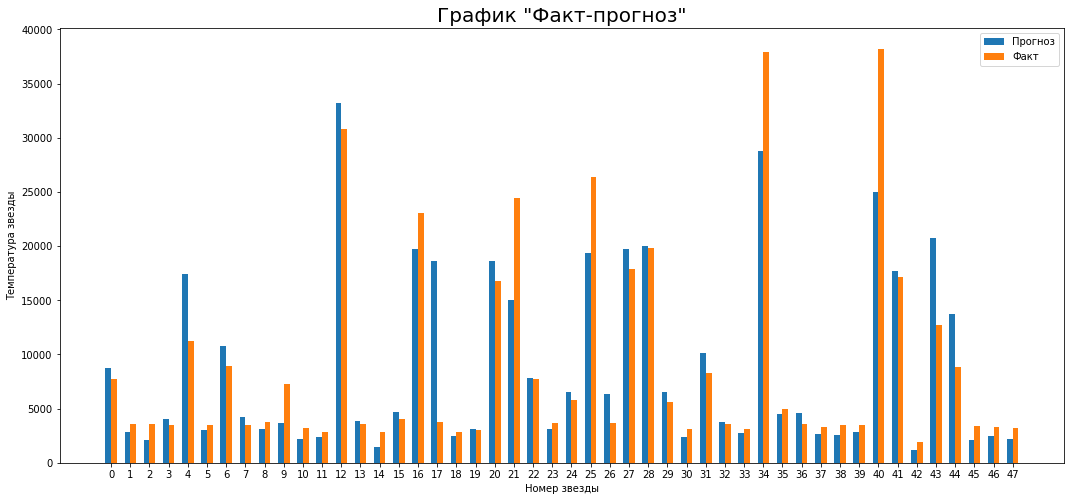

In [22]:
y1 = test_preds.detach().numpy().reshape([-1])
y2 = y_test.detach().numpy().reshape([-1])
x = np.arange(len(y1))

fig,ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(x)
first = ax.bar(x-0.15, y1, width = 0.3, label = 'Прогноз')
second = ax.bar(x+0.15, y2, width = 0.3, label = 'Факт')
ax.legend()
ax.set_title('График "Факт-прогноз"', fontsize=20)
ax.set_xlabel('Номер звезды')
ax.set_ylabel('Температура звезды')
plt.show()

## Улучшение нейронной сети

In [26]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,n_hidden_neurons_4, n_out_neurons, 
                 dropout_1, dropout_2, dropout_3, dropout_4):
        super(Model_improve, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(p=dropout_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)            
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=dropout_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.dp3 = nn.Dropout(p=dropout_3)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = nn.ReLU()
        self.dp4 = nn.Dropout(p=dropout_4)
        self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)        
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.dp4(x)
        x = self.fc5(x)
        
        return x

In [24]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [25]:
rmse_scorer = make_scorer(rmse)

In [27]:
skorch_regressor = NeuralNetRegressor(module=Model_improve, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=500, 
                                      lr=1e-3,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=30)),
            ],                                    ) 

In [28]:
params = {
    'module__dropout_1': [0.1, 0.2, 0.3, 0.4, 0.5],
    'module__dropout_2': [0.3, 0.4, 0.5, 0.6, 0.7],
    'module__dropout_3': [0.3, 0.4, 0.5, 0.6, 0.7],
    'module__dropout_4': [0.1, 0.2, 0.3, 0.4, 0.5],
    'module__n_hidden_neurons_1': range(10, 30, 5),
    'module__n_hidden_neurons_2': range(10, 30, 5),
    'module__n_hidden_neurons_3': range(10, 30, 5),
    'module__n_hidden_neurons_4': range(10, 30, 5),
    'module__n_in_neurons': [10],
    'module__n_out_neurons': [1]
}

In [29]:
%%time
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", verbose=3) 
grid.fit(X_train, y_train.reshape(-1,1)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch       RMSE      train_loss     valid_loss     dur
-------  ---------  --------------  -------------  ------
      1  9803.4170  212827286.7368  96106992.0000  0.0092
      2  9803.4102  212826910.3158  96106848.0000  0.0048
      3  9803.4023  212826797.4737  96106704.0000  0.0049
      4  9803.3945  212826517.8947  96106544.0000  0.0047
      5  9803.3867  212826483.3684  96106400.0000  0.0052
      6  9803.3779  212826206.3158  96106224.0000  0.0049
      7  9803.3701  212825901.4737  96106056.0000  0.0048
      8  9803.3613  212825416.4211  96105896.0000  0.0047
      9  9803.3535  212825398.7368  96105720.0000  0.0047
     10  9803.3438  212825189.8947  96105544.0000  0.0049
     11  9803.3350  212824894.3158  96105368.0000  0.0043
     12  9803.3252  212824581.8947  96105192.0000  0.0047
     13  9803.3164  212824371.3684  96105016.0000  0.0045
     14  9803.3076  212824330.1053  96104840.0000  0.0046
     15  98

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Model_improve'>,
),
                   param_distributions={'module__dropout_1': [0.1, 0.2, 0.3,
                                                              0.4, 0.5],
                                        'module__dropout_2': [0.3, 0.4, 0.5,
                                                              0.6, 0.7],
                                        'module__dropout_3': [0.3, 0.4, 0.5,
                                                              0.6, 0.7],
                                        'module__dropout_4': [0.1, 0.2, 0.3,
                                                              0.4, 0.5],
                                        'module__n_hidden_neurons_1': range(10, 30, 5),
                                        'module__n_hidden_neurons_2': range(10, 30, 5),
                                        'module__n_hidden_neur

In [30]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, grid.predict(X_test), squared=False)

7080.5312

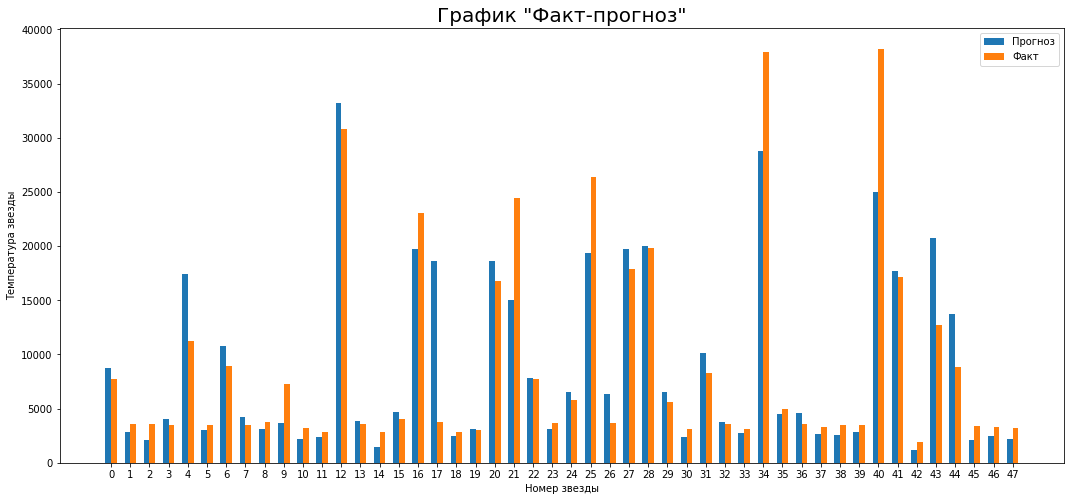

In [31]:
y1 = test_preds.detach().numpy().reshape([-1])
y2 = y_test.detach().numpy().reshape([-1])
x = np.arange(len(y1))

fig,ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(x)
first = ax.bar(x-0.15, y1, width = 0.3, label = 'Прогноз')
second = ax.bar(x+0.15, y2, width = 0.3, label = 'Факт')
ax.legend()
ax.set_title('График "Факт-прогноз"', fontsize=20)
ax.set_xlabel('Номер звезды')
ax.set_ylabel('Температура звезды')
plt.show()

## Выводы

В данном проекте, нам нужно было обучить нейронную сеть для предсказания температуры звезд, мы выполнили следующие шаги:
- Обучили нейронную сеть и добились достаточного значения на нашей метрике `RMSE`, а именно 4339.67.
- С помощью кросс-валидации, получилось получить ещё меньшее значение нашей метрики.
- Построили графики обучения, чтобы посмотреть, не переобучается / недообучается ли модель
- Построили графики "факт-прогноз"